In [48]:
"""
一些探索性工作，看tvc的影响情况
"""
import os
import pandas as pd
from scipy.io import loadmat
import networkx as nx
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# get data of a city
def get_mat_dataset(city):
    sources_directory = '/workspace/dataset/Foursquare/sources'
    city_mat_fp = os.path.join(sources_directory, 'dataset_connected_{city}.mat')
    mat_fp = city_mat_fp.format(city=city)
    mat_dict = loadmat(mat_fp)
    # print(mat_dict.keys())
    checkins_np = mat_dict['selected_checkins']
    friendship_new_np = mat_dict['friendship_new']
    friendship_old_np = mat_dict['friendship_old']
    users_np = mat_dict['selected_users_IDs']
    venue_np = mat_dict['selected_venue_IDs']
    # print(users_np.shape, venue_np.shape, checkins_np.shape, friendship_new_np.shape, friendship_old_np.shape)
    venues_df = pd.DataFrame(venue_np, columns=["vid"])
    venues_df.vid = venues_df.vid.map(lambda x: x[0])
    users_df = pd.DataFrame(users_np, columns=["uid"])
    checkins_df = pd.DataFrame(checkins_np, columns=['uid', 'time', 'vid', 'category'])
    friendship_new_df = pd.DataFrame(friendship_new_np, columns=['uid1', 'uid2'])
    friendship_old_df = pd.DataFrame(friendship_old_np, columns=['uid1', 'uid2'])
    # print('选定用户\n',users_df.head())
    # print('选定位置\n',venues_df.head())
    # print('朋友新\n',friendship_new_df.head())
    # print('朋友旧\n',friendship_old_df.head())
    # print('签到\n',checkins_df.head())

    # # 规范社交链接的数据，有friendship中有的点没有签到数据
    # set_check_usr = set(checkins_df['uid'])
    # delete_ind_friends = []
    # for ii in range(len(friendship_new_df)):
    #     if friendship_new_df['uid1'][ii] not in set_check_usr  or  friendship_new_df['uid2'][ii] not in set_check_usr:
    #         delete_ind_friends.append(ii)
    # friendship_new_df = friendship_new_df.drop(delete_ind_friends, axis=0)
    # friendship_new_df.index = range(0, len(friendship_new_df))
    #
    # delete_ind_friends = []
    # for ii in range(len(friendship_old_df)):
    #     if friendship_old_df['uid1'][ii] not in set_check_usr or friendship_old_df['uid2'][ii] not in set_check_usr:
    #         delete_ind_friends.append(ii)
    # friendship_old_df = friendship_old_df.drop(delete_ind_friends, axis=0)
    # friendship_old_df.index = range(0, len(friendship_old_df))
    #
    # # 签到中出现的friend没有的用户也删掉
    # set_friends_old_usr = set(friendship_old_df['uid1']) | set(friendship_old_df['uid2'])
    # delete_ind_check = []
    # for ii in range(len(checkins_df)):
    #     if checkins_df['uid'][ii] not in set_friends_old_usr:
    #         delete_ind_check.append(ii)
    # checkins_df = checkins_df.drop(delete_ind_check, axis=0)
    # checkins_df.index = range(0, len(checkins_df))
    #
    # # 新的社交关系出现的旧社交关系中没有的用户也删掉
    # delete_ind_friends = []
    # for ii in range(len(friendship_new_df)):
    #     if friendship_new_df['uid1'][ii] not in set_friends_old_usr or friendship_new_df['uid2'][ii] not in set_friends_old_usr:
    #         delete_ind_friends.append(ii)
    # friendship_new_df = friendship_new_df.drop(delete_ind_friends, axis=0)
    # friendship_new_df.index = range(0, len(friendship_new_df))

    return users_df, venues_df, checkins_df, friendship_new_df, friendship_old_df

# 对checkins的id重新赋值
def remakeID_checkins(checkins_df, friendship_new_df, friendship_old_df):
    set_u = set(checkins_df['uid']) | set(friendship_new_df['uid1']) | set(friendship_new_df['uid2']) | \
            set(friendship_old_df['uid1']) | set(friendship_old_df['uid2'])
    num_usr = len(set_u)
    num_time = len(set(checkins_df['time']))
    num_vid = len(set(checkins_df['vid']))
    num_category = len(set(checkins_df['category']))

    #偏移已考虑id从1开始
    timeID_offset = num_usr + 1
    vid_offset = timeID_offset + num_time
    category_offset = vid_offset + num_vid
    offset_DIC = {'time': timeID_offset, 'vid': vid_offset, 'category': category_offset}

    checkins_df.index = range(0, len(checkins_df))
    for ii in range(len(checkins_df)):
        checkins_df['time'][ii] = checkins_df['time'][ii] + timeID_offset - 1

    count_ID = -1
    last_ID = -1
    checkins_df.sort_values(by="vid", inplace=True, ascending=True)
    checkins_df.index = range(0, len(checkins_df))
    for ii in range(len(checkins_df)):
        tmp_ID = checkins_df['vid'][ii]
        if tmp_ID != last_ID:
            count_ID += 1
            last_ID = tmp_ID
            checkins_df['vid'][ii] = count_ID + vid_offset
        else:
            checkins_df['vid'][ii] = count_ID + vid_offset

    count_ID = -1
    last_ID = -1
    checkins_df.sort_values(by="category", inplace=True, ascending=True)
    checkins_df.index = range(0, len(checkins_df))
    for ii in range(len(checkins_df)):
        tmp_ID = checkins_df['category'][ii]
        if tmp_ID != last_ID:
            count_ID += 1
            last_ID = tmp_ID
            checkins_df['category'][ii] = count_ID + category_offset
        else:
            checkins_df['category'][ii] = count_ID + category_offset
    checkins_df.sort_values(by="uid", inplace=True, ascending=True)
    checkins_df.index = range(0, len(checkins_df))

    return offset_DIC

# get Graph
def get_Graph(friendship_old_df, friendship_new_df, checkins_df, offset_DIC):
    # 个数
    num_usr = offset_DIC["time"] - 1
    num_t = len(set(checkins_df['time']))
    num_v = len(set(checkins_df['vid']))
    num_c = len(set(checkins_df['category']))

    # 计算签到频次 user考虑id从1开始 tvc在偏移中考虑了id
    usr_t_pc_list = [[0 for _t in range(num_t)] for _ in range(num_usr + 1)]
    usr_v_pc_list = [[0 for _v in range(num_v)] for _ in range(num_usr + 1)]
    usr_c_pc_list = [[0 for _c in range(num_c)] for _ in range(num_usr + 1)]

    for uid, time, vid, cate in zip(checkins_df['uid'], checkins_df['time'], checkins_df['vid'], checkins_df['category']):
        usr_t_pc_list[uid][time - offset_DIC['time']] += 1
        usr_v_pc_list[uid][vid - offset_DIC['vid']] += 1
        usr_c_pc_list[uid][cate - offset_DIC['category']] += 1

    #构建带权二部图 hyperBipGraph
    bipG_t = nx.Graph()
    bipG_v = nx.Graph()
    bipG_c = nx.Graph()
    for uid in range(1,num_usr + 1):
        for tid in range(num_t):
            if usr_t_pc_list[uid][tid]>0:
                bipG_t.add_edge(uid, tid + offset_DIC['time'], weight=usr_t_pc_list[uid][tid])
        for vid in range(num_v):
            if usr_v_pc_list[uid][vid] > 0:
                bipG_v.add_edge(uid, vid + offset_DIC['vid'], weight=usr_v_pc_list[uid][vid])
        for cid in range(num_c):
            if usr_c_pc_list[uid][cid] > 0:
                bipG_c.add_edge(uid, cid + offset_DIC['category'], weight=usr_c_pc_list[uid][cid])

    # 构建未来社交图
    future_social_G = nx.Graph()
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        future_social_G.add_edge(uid1, uid2, weight=1)
    # 所有社交边的社交图
    all_social_G = nx.Graph()
    for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
        all_social_G.add_edge(uid1, uid2, weight=1)
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        all_social_G.add_edge(uid1, uid2, weight=1)

    return num_usr, num_t, num_v, num_c, bipG_t, bipG_v, bipG_c, future_social_G, all_social_G

# 计算共现次数
def count_co_num(edges, bipG):
    num_co = 0
    set_node = set(bipG.nodes)
    list_co_id = []
    for uid1, uid2 in edges:
        if uid1 in set_node:
            s1 = set(bipG.neighbors(uid1))
        else:
            s1 = set([])
        if uid2 in set_node:
            s2 = set(bipG.neighbors(uid2))
        else:
            s2 = set([])
        s3 = s1 & s2
        if len(s3) > 0:
            num_co += 1
            list_co_id += list(s3)
    return num_co, list_co_id

# tvc的影响力
def Impact_of_tvc(bipG_t, bipG_v, bipG_c, future_social_G, all_social_G):
    num_link = len(future_social_G.edges())
    # 看有未来有社交的用户有多少具有tvc共现
    num_Link_coT, list_co_id_T = count_co_num(future_social_G.edges(), bipG_t)
    num_Link_coV, list_co_id_V = count_co_num(future_social_G.edges(), bipG_v)
    num_Link_coC, list_co_id_C = count_co_num(future_social_G.edges(), bipG_c)

    # 看未来无社交的用户有多少具有tvc共现 无社交用户采样和有社交的等数量的
    nonLink_sample = random.choices(list(nx.complement(all_social_G).edges()), k=num_link)
    num_nonLink_coT, _ = count_co_num(nonLink_sample, bipG_t)
    num_nonLink_coV, _ = count_co_num(nonLink_sample, bipG_v)
    num_nonLink_coC, _ = count_co_num(nonLink_sample, bipG_c)

    # 各种共现计算结果
    num_link_coT_div_all = num_Link_coT / num_link
    num_nonLink_coT_div_all = num_nonLink_coT / num_link
    num_link_coV_div_all = num_Link_coV / num_link
    num_nonLink_coV_div_all = num_nonLink_coV / num_link
    num_link_coC_div_all = num_Link_coC / num_link
    num_nonLink_coC_div_all = num_nonLink_coC / num_link

    result = {
        'link_coT_ratio': num_link_coT_div_all,
        'nonLink_coT_ratio': num_nonLink_coT_div_all,
        'link_coV_ratio': num_link_coV_div_all,
        'nonLink_coV_ratio': num_nonLink_coV_div_all,
        'link_coC_ratio': num_link_coC_div_all,
        'nonLink_coC_ratio': num_nonLink_coC_div_all,
        'T_counter': Counter(list_co_id_T),
        'V_counter': Counter(list_co_id_V),
        'C_counter': Counter(list_co_id_C),
    }
    return result

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

def draw_pic(result_all):
    # 结果绘制
    col = 3
    city_Name = result_all.keys()
    fig, axes = plt.subplots(1, col, figsize=(20, 6))
    # 先绘制上面三排
    key_list = [['link_coT_ratio', 'nonLink_coT_ratio'],
                ['link_coV_ratio', 'nonLink_coV_ratio'],
                ['link_coC_ratio', 'nonLink_coC_ratio']]
    Counter_name_list = ['T_counter', 'V_counter', 'C_counter']
    ylabel = ['ratio_of_T','ratio_of_V','ratio_of_C']
    for tmp_col in range(col):
        link_list = []
        nonLink_list = []
        for city in city_Name:
            link_list.append(round(result_all[city][key_list[tmp_col][0]], 2))
            nonLink_list.append(round(result_all[city][key_list[tmp_col][1]], 2))
        # 绘制柱状图
        x = np.arange(len(city_Name))  # the label locations
        width = 0.35  # the width of the bars

        rects1 = axes[tmp_col].bar(x - width / 2, link_list, width, label='link_co_ratio')
        rects2 = axes[tmp_col].bar(x + width / 2, nonLink_list, width, label='unLink_co_ratio')
        axes[tmp_col].set_ylabel(ylabel[tmp_col])
        # axes[tmp_row, tmp_col].set_title('Scores by group and gender')
        axes[tmp_col].set_xticks(x)
        axes[tmp_col].set_xticklabels(city_Name)

        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                axes[tmp_col].annotate('{}'.format(height),
                                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                                xytext=(0, 3),  # 3 points vertical offset
                                                textcoords="offset points",
                                                ha='center', va='bottom')
        autolabel(rects1)
        autolabel(rects2)
    legend = ['link_co_ratio', 'nonLink_co_ratio']
    fig.legend(legend, loc='upper center', ncol=len(legend),bbox_to_anchor=(0.5, 1.05), fontsize=15)  # 绘制前len(methods)个图例
    plt.tight_layout()
    plt.savefig('impact_Mobility.jpg', dpi=200, bbox_inches='tight')
    plt.show()

In [2]:
cities = ["Istanbul", "Jakarta", "KualaLampur", "NYC", "SaoPaulo", "TKY"]
# cities = ["NYC", "SaoPaulo"]
# cities = ["Istanbul", "Jakarta", "KualaLampur", "TKY"]

citiy_2_shortName = {"Istanbul": 'IST', "Jakarta": 'JK', "KualaLampur": 'KL', "NYC": 'NYC', "SaoPaulo": 'SP',
                         "TKY": 'TKY'}
result_all = {}
for city in cities:
    print("*" * 20, "开始处理" + city + "的数据", "*" * 20)
    # get data
    print("-" * 10, "读取" + city + "原数据", "-" * 10)
    users_df, venues_df, checkins_df, friendship_new_df, friendship_old_df = get_mat_dataset(city)

    # 重新编排id
    print("-" * 10, "重新编排id", "-" * 10)
    offset_DIC = remakeID_checkins(checkins_df, friendship_new_df, friendship_old_df)

    # 构建异构超图
    print("-" * 10, "构建异构超图", "-" * 10) # 用未来的社交关系进行构建
    num_u, num_t, num_v, num_c, bipG_t, bipG_v, bipG_c, future_social_G, all_social_G = \
        get_Graph(friendship_old_df, friendship_new_df, checkins_df, offset_DIC)

    result = Impact_of_tvc(bipG_t, bipG_v, bipG_c, future_social_G, all_social_G)
    result_all[citiy_2_shortName[city]] = result

******************** 开始处理Istanbul的数据 ********************
---------- 读取Istanbul原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------
******************** 开始处理Jakarta的数据 ********************
---------- 读取Jakarta原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------
******************** 开始处理KualaLampur的数据 ********************
---------- 读取KualaLampur原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------
******************** 开始处理NYC的数据 ********************
---------- 读取NYC原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------
******************** 开始处理SaoPaulo的数据 ********************
---------- 读取SaoPaulo原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------
******************** 开始处理TKY的数据 ********************
---------- 读取TKY原数据 ----------
---------- 重新编排id ----------
---------- 构建异构超图 ----------


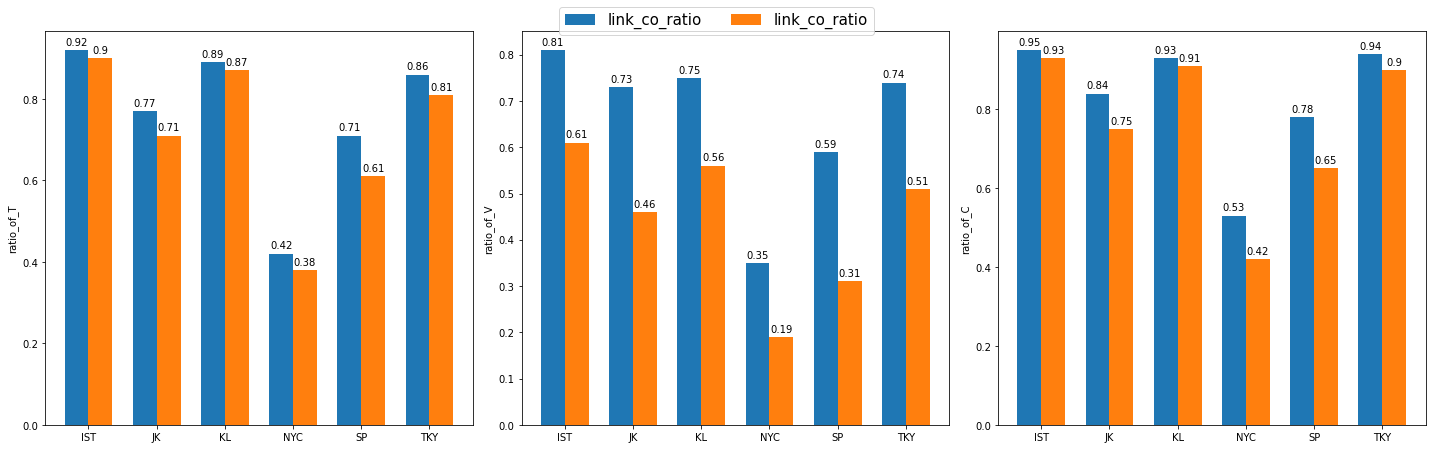

In [49]:
draw_pic(result_all)

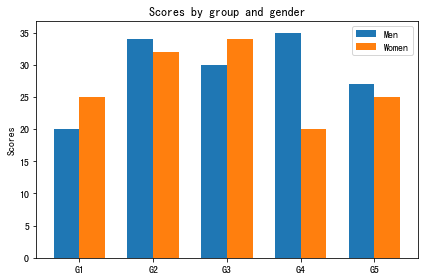

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
 
plt.rcParams['font.sans-serif'] = ['SimHei']
 
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
 
x = np.arange(len(labels)) # the label locations
width = 0.35 # the width of the bars
 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
 
 
# def autolabel(rects):
#      """Attach a text label above each bar in *rects*, displaying its height."""
#      for rect in rects:
#          height = rect.get_height()
#          ax.annotate('{}'.format(height),
#                      xy=(rect.get_x() + rect.get_width() / 2, height),
#                      xytext=(0, 3), # 3 points vertical offset
#                      textcoords="offset points",
#                      ha='center', va='bottom')
 
 
# autolabel(rects1)
# autolabel(rects2)
 
fig.tight_layout()
 
plt.show()